In [2]:
import numpy as np
import pandas as pd

from pyinform.dist import Dist
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima.model import ARIMA

from scipy.stats import entropy

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from statsmodels.tsa.stattools import pacf 
from pandas.plotting import autocorrelation_plot

from sklearn.metrics import mutual_info_score

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('bmh')
import seaborn as sns

### $AR(1)$ 
#### $S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$

In [3]:
np.random.seed(42)

ar = np.array([1, -0.9]) # MU(constant)=1, PHI=0.9 (MOMENTUM)
ma = np.array([1])

process = ArmaProcess(ar, ma)
series = process.generate_sample(1000, )

In [4]:
print(f'mu: {np.mean(series)}')
print(f'sigma: {np.std(series)}')
print(f'sigma2: {np.var(series)}')

mu: 0.19626089593974705
sigma: 2.241191499090931
sigma2: 5.022939335597455


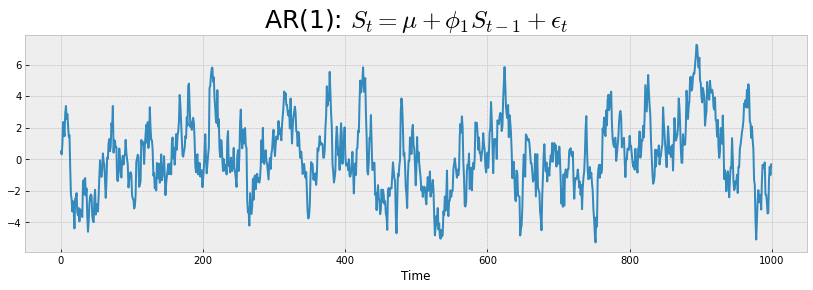

In [5]:
plt.figure(figsize=(14,4))
plt.title('AR(1): '+'$S_t = \mu + \phi_1 S_{t-1} + \epsilon_t$', fontsize=25)
plt.plot(series)
plt.xlabel('Time')
plt.show()

In [29]:
data = pd.DataFrame({'ar':series})
s_dict = {}
n_series = 6
for s in range(n_series):
    idx = s
    name = 'l'+str(idx)
    s_dict[name] = idx
    data[name] = data['ar'].shift(idx)
data.head()

,ar,l0,l1,l2,l3,l4,l5
0,0.496714,0.496714,NaN,NaN,NaN,NaN,NaN
1,0.308778,0.308778,0.496714,NaN,NaN,NaN,NaN
2,0.925589,0.925589,0.308778,0.496714,NaN,NaN,NaN
3,2.356060,2.356060,0.925589,0.308778,0.496714,NaN,NaN
4,1.886301,1.886301,2.356060,0.925589,0.308778,0.496714,NaN


In [30]:
data.corr()

,ar,l0,l1,l2,l3,l4,l5
ar,1.000000,1.000000,0.899631,0.810859,0.731175,0.656544,0.600965
l0,1.000000,1.000000,0.899631,0.810859,0.731175,0.656544,0.600965
l1,0.899631,0.899631,1.000000,0.899659,0.810848,0.731196,0.657030
l2,0.810859,0.810859,0.899659,1.000000,0.899668,0.810788,0.731381
l3,0.731175,0.731175,0.810848,0.899668,1.000000,0.899701,0.811380
l4,0.656544,0.656544,0.731196,0.810788,0.899701,1.000000,0.900009
l5,0.600965,0.600965,0.657030,0.731381,0.811380,0.900009,1.000000


In [31]:
y_series = 'l4'

x = data['ar'].values
y = data[y_series].values

x = x[s_dict[y_series]:]
y = y[s_dict[y_series]:]

In [50]:
state_set = np.arange(4, 31, 5) #number of bins for MI
state_set

array([ 4,  9, 14, 19, 24, 29])

In [62]:
states = 10

big_correlations = []
big_informations = []

for states in state_set:
    correlations = []
    informations = []
    print(f'States={states}','='*100)
    for serie in s_dict.keys():
        #print(f'Serie: {states}')
        x = data['ar'].values
        y = data[serie].values

        x = x[s_dict[serie]:]
        y = y[s_dict[serie]:]

        pxy, xbin, ybin = np.histogram2d(x, y, bins=states)
        joint = pxy/pxy.sum()
        qX = joint.sum(1)
        qY = joint.sum(0)

        hX = entropy(qX, base=2)
        hY = entropy(qY, base=2)

        pX_Y = joint / qY

        hX_Y =  np.sum(qY * np.log2(np.e) * np.apply_along_axis(entropy, 0, pX_Y))

        miXY = hX - hX_Y

        correlations.append(np.corrcoef(x, y)[0,1])
        informations.append(miXY)

        #print(f'Corr: {np.corrcoef(x, y)[0,1]:.3f}')
        #print(f'H(X): {hX:.3f} bits')
        #print(f'H(Y): {hY:.3f} bits')
        #print(f'I(X:Y): {miXY:.3f} bits | Reduction in the description of X')
        print(f'Reduction (lag={serie}): {miXY / hX :.3f}%')
        #print('')
    big_correlations.append(correlations)
    big_informations.append(informations)

States=4 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.408%
Reduction (lag=l2): 0.306%
Reduction (lag=l3): 0.221%
Reduction (lag=l4): 0.175%
Reduction (lag=l5): 0.144%
States=9 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.374%
Reduction (lag=l2): 0.262%
Reduction (lag=l3): 0.196%
Reduction (lag=l4): 0.152%
Reduction (lag=l5): 0.123%
States=14 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.340%
Reduction (lag=l2): 0.238%
Reduction (lag=l3): 0.184%
Reduction (lag=l4): 0.142%
Reduction (lag=l5): 0.121%
States=19 ====================================================================================================
Reduction (lag=l0): 1.000%
Reduction (lag=l1): 0.324%
Reduction (lag=l2)

In [63]:
summary = pd.DataFrame({'signal':[0,1,2,3,4,5],
                     'corr':correlations})
for idx, mi in zip(state_set, big_informations):
    name = 'mi_'+str(idx)
    #print(name)
    summary[name] = mi
summary

,signal,corr,mi_4,mi_9,mi_14,mi_19,mi_24,mi_29
0,0,1.000000,1.653508,2.718963,3.355513,3.773745,4.116553,4.378213
1,1,0.899631,0.675435,1.017514,1.142542,1.222367,1.298619,1.382731
2,2,0.810859,0.506574,0.712637,0.800159,0.880689,0.954704,1.060824
3,3,0.731175,0.366231,0.532630,0.616843,0.711177,0.771541,0.878021
4,4,0.656544,0.288908,0.413066,0.476370,0.548104,0.694932,0.804324
5,5,0.600965,0.238324,0.335402,0.406566,0.518928,0.632262,0.760376


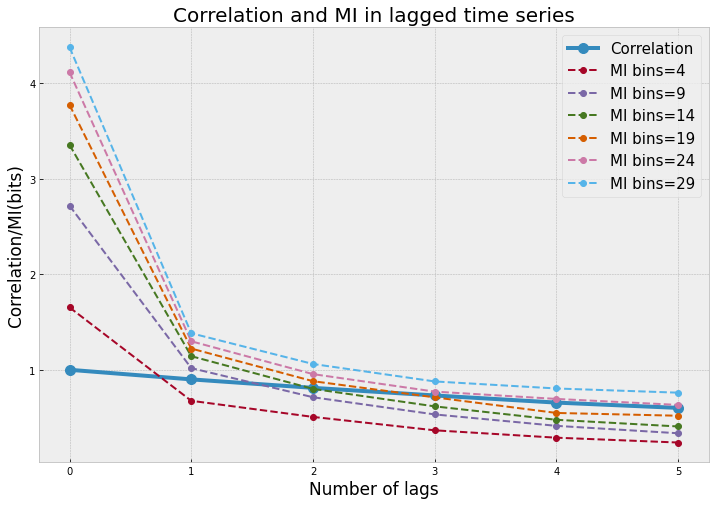

In [64]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.title('Correlation and MI in lagged time series', fontsize=20)
ax.plot(summary['signal'], 
        summary['corr'],
        linewidth=4, 
        marker = 'o',
        markersize=10,
        label='Correlation')
for s in summary.columns[2:]:
    ax.plot(summary['signal'], summary[s], linestyle='--', marker = 'o', label=f'MI bins={s[3:]}')

ax.set_xticks(summary.signal)
plt.legend(fontsize=15)
plt.xlabel('Number of lags', fontsize=17)
plt.ylabel('Correlation/MI(bits)', fontsize=17)
plt.show()